***Importing Libraries***

In [1]:
import gym
import numpy as np
from collections import deque
import random
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
import gym
import numpy as np
import renom as rm
from collections import deque
import matplotlib.pyplot as plt
from renom_rl.discrete.double_dqn import DoubleDQN
from renom_rl.environ.env import BaseEnv
from renom_rl.utility.filter import EpsilonEIFilter
from renom_rl.utility import Animation
from renom.optimizer import Adam as AdamR
from renom.cuda import set_cuda_active
set_cuda_active(False)

***Initialization of Environment***

In [3]:
class MountainCar(BaseEnv):
    
    def __init__(self):
        self.env = gym.make('MountainCar-v0') 
        self.action_shape = (self.env.action_space.n,)
        self.state_shape = self.env.observation_space.shape
        #print("Env Space : ", self.state_shape)
        #print("Action Space : ", self.action_shape)
        
        self.animation = Animation()
        self.test_mode = False
    
    def reset(self):
        return self.env.reset()
    
    def sample(self):
        return self.env.action_space.sample()
    
    def step(self, action):
        state, reward, terminal, _ = self.env.step(int(action))
        #reward = 0
        
        #if terminal:
            #if state[0] > 0.5:
                #reward = 1
            #else:
                #reward = state[0] + 0.5
         
        return state, reward, terminal
    
    def test_start(self):
        self.animation.reset()
        self.env.reset()
    
    def test_epoch_step(self):
        pass
        #self.animation.store(self.env.render(mode="rgb_array"))
    
    def test_close(self):
        #self.env.close() 
        self.env.viewer = None
                
MC = MountainCar()
st_shape=MC.state_shape[0]
act_shape=MC.action_shape[0]

q_network = rm.Sequential([rm.Dense(100),
                                                   rm.Relu(),
                                                   rm.Dense(100),
                                                   rm.Relu(),
                                                   rm.Dense(act_shape)
                                                ])


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
action_list = [0,1,2]
gamma =0.45
lr =0.001
num_episodes =1000
epsilon =1
epsilon_decay =0.995
memory_size =1000
batch_size=100
show=False


In [20]:
factor=[1,100]

[1, 100]

In [6]:
memory=deque(maxlen=memory_size)
s=MC.reset()
s = s.reshape((1,-1))
s = s*factor
for _ in range(memory_size):
    a = np.random.randint(0,act_shape)
    new_s,r,d =MC.step(a)
    new_s = new_s.reshape((1,-1))
    new_s = new_s*factor
    if show:
        MC.render()
    if d:
        r=-100
        experience =(s,r,a,new_s,d)
        s=MC.reset()
        s = s.reshape((1,-1))
    else:    
        experience =(s,r,a,new_s,d)
    memory.append(experience)
    s = new_s
  

***Model Definition***

Here , I have defined the model as a simple MLP neural network with 2 hidden layers of 100 nodes with ```relu``` activation function

In [8]:
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(st_shape,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(act_shape,activation='linear'))
model.compile(loss='mse',optimizer=Adam(lr=lr),)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 10,703
Trainable params: 10,703
Non-trainable params: 0
_________________________________________________________________


In [17]:
ep_list =[]
reward_list =[] 
index=0 
oh = OneHotEncoder(categories=[range(3)])
for ep in range(num_episodes):
    s= MC.reset()
    s=s.reshape((1,-1))
    s = s*factor
    total_rewards =0
    d = False
    j = 0
    for j in range(200):
        if np.random.random()< epsilon:
            a = np.random.randint(0,len(action_list))
        else:
            Q = model.predict(s.reshape(1,-1))
            a =np.argmax(Q)
        new_s,r,d = MC.step(a)
        new_s = new_s.reshape((1,-1))
        new_s = new_s*factor
        total_rewards=total_rewards+r
        if show:
            MC.render()
        if d:
            if total_rewards<-199:
                r =-100
                experience = (s,r,a,new_s,d)
                memory.append(experience)
                print("Episode %d, Failed! Reward %d"%(ep,total_rewards))
            elif total_rewards<-110 and total_rewards>-199:
                r=10
                d=True
                experience = (s,r,a,new_s,d)
                memory.append(experience)
                print("Episode %d, Better! Reward %d"%(ep,total_rewards))
            elif total_rewards>=-110:
                r=100
                experience = (s,r,a,new_s,d)
                memory.append(experience)

                print("Episode %d, Passed! Reward %d"%(ep,total_rewards))
            ep_list.append(ep)
            reward_list.append(total_rewards)
            break
        
        experience = (s,r,a,new_s,d)
        memory.append(experience)
        if j==199:
            print("Reward %d after full episode"%(total_rewards))
            
        s = new_s
    batches=random.sample(memory,batch_size)
    states= np.array([batch[0] for batch in batches],ndmin=3).reshape(len(batches),-1)
    rewards= np.array([batch[1] for batch in batches])
    actions= np.array([batch[2] for batch in batches])
    actions=oh.fit_transform(actions.reshape(-1,1)).toarray()
    actions = actions.reshape(-1,1,act_shape)
    new_states= np.array([batch[3] for batch in batches],ndmin=3).reshape(len(batches),-1)
    dones= np.array([batch[4] for batch in batches])
    Qs =model.predict(states)
    new_Qs = model.predict(new_states)
    target_Qs=rewards+gamma*(np.max(new_Qs,axis=1)*(~dones))
    Qs[actions==1]=target_Qs#.reshape(-1,)
    model.fit(states,Qs,verbose=0 )
    epsilon=epsilon*epsilon_decay


Episode 0, Failed! Reward -200


IndexError: too many indices for array

In [19]:
Qs.shape,actions.shape

((100, 3), (100, 1, 3))

Text(0,0.5,'Rewards')

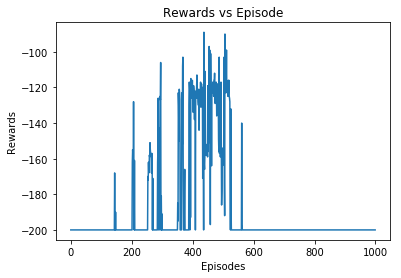

In [8]:
plt.plot(reward_list)
plt.title("Rewards vs Episode")
plt.xlabel("Episodes")
plt.ylabel("Rewards")